In [1]:
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gspec
import pickle as pkl
import copy
from scipy.integrate import quad
from scipy.optimize import curve_fit


In [2]:
SIM = 'tng100'
SNAP = 50
hisubf = pkl.load(open('/home/cosinga/scratch/hcolor/output/alt_%sB_%03dS_0A_800R/results/hisubhalogrid_%sB_%03dS_0A_800R.pkl_rlib.pkl'%(SIM, SNAP, SIM, SNAP), 'rb'))
hiptlf = pkl.load(open('/home/cosinga/scratch/hcolor/output/alt_%sB_%03dS_0A_800R/results/hiptlgrid_%sB_%03dS_0A_800R.pkl_rlib.pkl'%(SIM, SNAP, SIM, SNAP), 'rb'))
vnf = pkl.load(open('/home/cosinga/scratch/hcolor/output/alt_%sB_%03dS_0A_800R/results/vngrid_%sB_%03dS_0A_800R.pkl_rlib.pkl'%(SIM, SNAP, SIM, SNAP), 'rb'))
ptlf = pkl.load(open('/home/cosinga/scratch/hcolor/output/alt_%sB_%03dS_0A_800R/results/ptlgrid_%sB_%03dS_0A_800R.pkl_rlib.pkl'%(SIM, SNAP, SIM, SNAP), 'rb'))


In [3]:
# get desired 2Dpk for GD14 model
for d in hisubf.results['2Dpk']:
    if 'm_hi_GD14_vol' == d.getProp('model'):
        print('model found')
        if d.getProp('space') == 'real':
            gal_real = d.getValues()
        else:
            gal_red = d.getValues()
for d in hiptlf.results['2Dpk']:
    if 'GD14' == d.getProp('model'):
        print('model found')
        if d.getProp('space') == 'real':
            ptl_real = d.getValues()
        else:
            ptl_red = d.getValues()
for d in vnf.results['2Dpk']:
    if d.getProp('space') == 'real':
        print('real found')
        vn_real = d.getValues()
    else:
        print('redshift found')
        vn_red = d.getValues()

model found
model found
model found
model found
real found
redshift found


In [20]:
# get the auto powers and biases
for d in ptlf.results['pk']:
    
    if d.getProp('space') == 'real' and d.getProp('ptl_species') == 'ptl':
        print('ptl found')
        matter_auto = d.getValues()[1]

for d in hisubf.results['pk']:
    if 'm_hi_GD14_vol' == d.getProp('model'):
        print('model found')
        if d.getProp('space') == 'real':
            gal_auto = d.getValues()
            gal_bias = np.sqrt(gal_auto[1] / matter_auto)
#         else:
#             gal_bias = d.getValues()
#             gal_bias = np.sqrt(gal_bias[1] / matter_zspace)

for d in hiptlf.results['pk']:
    if 'GD14' == d.getProp('model'):
        print('model found')
        if d.getProp('space') == 'real':
            ptl_auto = d.getValues()
            ptl_bias = np.sqrt(ptl_auto[1] / matter_auto)
#         else:
#             ptl_bias = d.getValues()
#             ptl_bias = np.sqrt(ptl_bias[1] / matter_zspace)


for d in vnf.results['pk']:
    if d.getProp('space') == 'real':
        print('real found')
        vn_auto = d.getValues()
        vn_bias = np.sqrt(vn_auto[1] / matter_auto)
        
#     else:
#         print('redshift found')
#         vn_bias = d.getValues()
        
#         vn_bias = np.sqrt(vn_bias[1] / matter_zspace)





if SNAP == 67:
    omega_m = 0.6037
elif SNAP == 50:
    omega_m = 0.7829
f = omega_m ** 0.545
   

ptl found
model found
model found
model found
model found
real found


In [21]:
def gal_fit(ks, sigma):
    kpar = ks[0]
    kper = ks[1]
    k = np.sqrt(kper**2 + kpar**2)
    mu = kpar / k
    bias_interp = np.interp(np.log10(k), np.log10(gal_auto[0]), np.log10(gal_bias))
    bias = 10**bias_interp
    kaiser = (1 + f/bias * mu**2)**2
    auto_interp = np.interp(np.log10(k), np.log10(gal_auto[0]), np.log10(gal_auto[1]))
    auto = 10**auto_interp
    fog = (1 + 0.5 * k ** 2 * mu ** 2 * sigma**2)**(-2)
    return kaiser * auto * fog

def ptl_fit(ks, sigma):
    kpar = ks[0]
    kper = ks[1]
    k = np.sqrt(kper**2 + kpar**2)
    mu = kpar / k
    bias_interp = np.interp(np.log10(k), np.log10(ptl_auto[0]), np.log10(ptl_bias))
    bias = 10**bias_interp
    kaiser = (1 + f/bias * mu**2)**2
    auto_interp = np.interp(np.log10(k), np.log10(ptl_auto[0]), np.log10(ptl_auto[1]))
    auto = 10**auto_interp
    fog = (1 + 0.5 * k ** 2 * mu ** 2 * sigma**2)**(-2)
    return kaiser * auto * fog

def vn_fit(ks, sigma):
    kpar = ks[0]
    kper = ks[1]
    k = np.sqrt(kper**2 + kpar**2)
    mu = kpar / k
    bias_interp = np.interp(np.log10(k), np.log10(vn_auto[0]), np.log10(vn_bias))
    bias = 10**bias_interp
    kaiser = (1 + f/bias * mu**2)**2
    auto_interp = np.interp(np.log10(k), np.log10(vn_auto[0]), np.log10(vn_auto[1]))
    auto = 10**auto_interp
    fog = (1 + 0.5 * k ** 2 * mu ** 2 * sigma**2)**(-2)
    return kaiser * auto * fog

def plot_pk(ax, cax, pk2d, cmap = 'viridis', vlim = [0, 4.5], nlevels = 100, cont_spacing = 0.5, smooth_sigma = 0.6):
    plt.sca(ax)
    vmin, vmax = vlim
    norm = mpl.colors.Normalize(vmin, vmax)
    nlevels = 100
    kpar = np.unique(pk2d[0])
    kper = np.unique(pk2d[1])
    KPAR, KPER = np.meshgrid(kpar, kper)
    pk = np.reshape(pk2d[2], KPAR.shape)
    levels = np.linspace(vmin, vmax, nlevels)
    lo_mask = pk <= 10**vmin
    hi_mask = pk > 10**vmax
    pk[lo_mask] = 10**vmin
    pk[hi_mask] = 10**vmax
    plt.contourf(KPAR, KPER, np.log10(pk), levels = levels, cmap = cmap, vmin = vmin, vmax = vmax)
    smap = mpl.cm.ScalarMappable(norm = norm, cmap = cmap)
    plt.colorbar(smap, cax = cax)
#     data = gaussian_filter(np.log10(pk), sigma = smooth_sigma)
#     plt.contour(KPAR, KPER, data, levels = np.arange(vmin, vmax+cont_spacing, cont_spacing), colors = 'black')
#     circles = np.sqrt(np.log10(KPAR) ** 2 + np.log10(KPER) **2)
#     plt.contour(KPAR, KPER, circles, levels = 100, colors = 'black', linestyles = ':')
    plt.xlim(.1, 5)
    plt.ylim(.1, 5)
    plt.xscale('log')
    plt.yscale('log')
    return

In [22]:
def calc_monopole(auto, hi_bias, sigma_p):
    def monopole(mu, k, auto_power, bias, sigma):
        bias_interp = np.interp(np.log10(k), np.log10(auto_power[0]), np.log10(bias))
        bhi = 10**bias_interp
        kaiser = (1 + f/bhi * mu **2)**2
        auto_interp = np.interp(np.log10(k), np.log10(auto_power[0]), np.log10(auto_power[1]))
        auto = 10**auto_interp
        fog = (1 + 0.5 * k ** 2 * mu ** 2 * sigma**2)**(-2)
        return 0.5 * kaiser * auto * fog

    # for each k value in the auto power, integrate mu from -1 to 1
    int_res = np.zeros_like(auto[0])
    for i in range(len(auto[0])):
        res = quad(monopole, -1, 1, args = (auto[0][i], auto, hi_bias, sigma_p))
        int_res[i] = res[0]
    return int_res

In [39]:
func_dict = {'vn':vn_fit, 'hisub':gal_fit, 'hiptl':ptl_fit}
auto_dict = {'vn':vn_auto, 'hisub':gal_auto, 'hiptl':ptl_auto}
red_dict = {'vn':vn_red, 'hisub':gal_red, 'hiptl':ptl_red}
bias_dict = {'vn':vn_bias, 'hisub':gal_bias, 'hiptl':ptl_bias}
sigma_dict = {}
int_dict = {}
mask_type = 'k_all'

def mask_ks(mask_type, kpar, kper):
    if mask_type == 'k_sep_and':
        return (kpar < 1) & (kper < 1)
    elif mask_type == 'k_sep_or':
        return (kpar < 1) | (kper < 1)
    elif mask_type == 'k_all':
        return np.sqrt(kpar ** 2 + kper ** 2) < 1

for i in ['vn', 'hisub', 'hiptl']:
    red2D = red_dict[i]
    mask = mask_ks(mask_type, red2D[0], red2D[1])
    print(np.sum(mask))
    xdata = np.zeros((2, np.sum(mask)))
    xdata[0, :] = red2D[0][mask]
    xdata[1, :] = red2D[1][mask]
    sigma, cov = curve_fit(func_dict[i], xdata, red2D[2][mask], p0 = 1.5, bounds = [0, 5])
    print(i, cov)
    sigma_dict[i] = sigma
    
    int_dict[i] = calc_monopole(auto_dict[i], bias_dict[i], sigma)


112
vn [[0.68845697]]
112
hisub [[0.8179174]]
112
hiptl [[0.77486345]]


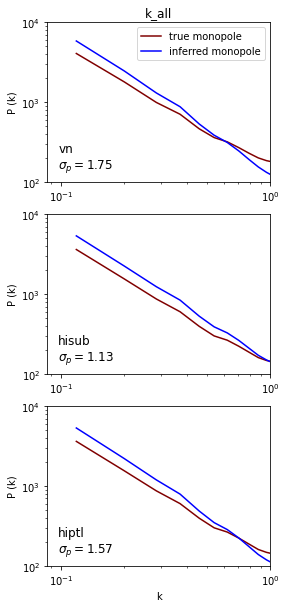

In [40]:

fig, axes = plt.subplots(3, 1, figsize = (4, 10))
for i, fname in enumerate(['vn', 'hisub', 'hiptl']):
    auto = auto_dict[fname]
    plt.sca(axes[i])
    plt.plot(auto[0], auto[1], label = 'true monopole', color = 'maroon')
    plt.plot(auto[0], int_dict[fname], label = 'inferred monopole', color = 'blue')
    plt.loglog()
    plt.xlim(0.086, 1)
    plt.ylim(1e2, 1e4)
    plt.ylabel('P (k)')
    if i == 0:
        plt.title(mask_type)
        plt.legend()
    elif i == 2:
        plt.xlabel('k')
    plt.text(0.05, 0.05, '%s\n$\\sigma_p = %.2f$'%(fname, sigma_dict[fname]), transform = axes[i].transAxes, va = 'bottom',
            ha = 'left', fontsize = 12)
#     plt.sca(axes[i, 1])
#     plt.xlim(0.086, 1)

#     plt.plot(auto[0], (int_dict[fname] - auto[1]) / auto[1] * 100)
#     plt.ylim(-50, 50)


(50, 200)

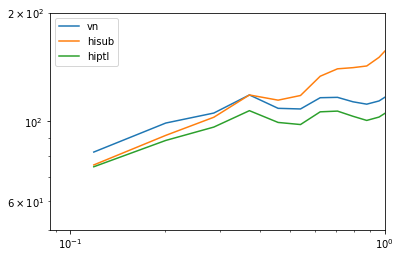

In [28]:
for i, fname in enumerate(['vn', 'hisub', 'hiptl']):
    auto = auto_dict[fname]
    plt.plot(auto[0], int_dict[fname] * auto[0]**2, label = fname)
plt.legend()
plt.loglog()
plt.xlim(0.086, 1)
plt.ylim(50, 200)

In [ ]:
def new_fit()